In [ ]:
!pip install -U spacy

In [ ]:
import re
import string
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.pipeline import Pipeline
from sklearn.base import TransformerMixin
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix
import spacy
from spacy.lang.en.stop_words import STOP_WORDS
from spacy.lang.en import English

In [ ]:
data_fake = pd.read_csv("fake_job_postings.csv")
data_fake.head()

,job_id,title,location,department,salary_range,company_profile,description,requirements,benefits,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function,fraudulent
0,1,Marketing Intern,"US, NY, New York",Marketing,NaN,"We're Food52, and we've created a groundbreaki...","Food52, a fast-growing, James Beard Award-winn...",Experience with content management systems a m...,NaN,0,1,0,Other,Internship,NaN,NaN,Marketing,0
1,2,Customer Service - Cloud Video Production,"NZ, , Auckland",Success,NaN,"90 Seconds, the worlds Cloud Video Production ...",Organised - Focused - Vibrant - Awesome!Do you...,What we expect from you:Your key responsibilit...,What you will get from usThrough being part of...,0,1,0,Full-time,Not Applicable,NaN,Marketing and Advertising,Customer Service,0
2,3,Commissioning Machinery Assistant (CMA),"US, IA, Wever",NaN,NaN,Valor Services provides Workforce Solutions th...,"Our client, located in Houston, is actively se...",Implement pre-commissioning and commissioning ...,NaN,0,1,0,NaN,NaN,NaN,NaN,NaN,0
3,4,Account Executive - Washington DC,"US, DC, Washington",Sales,NaN,Our passion for improving quality of life thro...,THE COMPANY: ESRI – Environmental Systems Rese...,"EDUCATION: Bachelor’s or Master’s in GIS, busi...",Our culture is anything but corporate—we have ...,0,1,0,Full-time,Mid-Senior level,Bachelor's Degree,Computer Software,Sales,0
4,5,Bill Review Manager,"US, FL, Fort Worth",NaN,NaN,SpotSource Solutions LLC is a Global Human Cap...,JOB TITLE: Itemization Review ManagerLOCATION:...,QUALIFICATIONS:RN license in the State of Texa...,Full Benefits Offered,0,1,1,Full-time,Mid-Senior level,Bachelor's Degree,Hospital & Health Care,Health Care Provider,0


In [ ]:
data_fake.shape

(17880, 18)

In [ ]:
data_fake.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17880 entries, 0 to 17879
Data columns (total 18 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   job_id               17880 non-null  int64 
 1   title                17880 non-null  object
 2   location             17534 non-null  object
 3   department           6333 non-null   object
 4   salary_range         2868 non-null   object
 5   company_profile      14572 non-null  object
 6   description          17879 non-null  object
 7   requirements         15185 non-null  object
 8   benefits             10670 non-null  object
 9   telecommuting        17880 non-null  int64 
 10  has_company_logo     17880 non-null  int64 
 11  has_questions        17880 non-null  int64 
 12  employment_type      14409 non-null  object
 13  required_experience  10830 non-null  object
 14  required_education   9775 non-null   object
 15  industry             12977 non-null  object
 16  func

In [ ]:
data_fake.isnull().sum()

job_id                     0
title                      0
location                 346
department             11547
salary_range           15012
company_profile         3308
description                1
requirements            2695
benefits                7210
telecommuting              0
has_company_logo           0
has_questions              0
employment_type         3471
required_experience     7050
required_education      8105
industry                4903
function                6455
fraudulent                 0
dtype: int64

In [ ]:
columns = [ 'telecommuting', 'has_company_logo', 'has_questions', 'salary_range']
for colu in columns:
  del data_fake[colu]

In [ ]:
data_fake.head()

,job_id,title,location,department,company_profile,description,requirements,benefits,employment_type,required_experience,required_education,industry,function,fraudulent
0,1,Marketing Intern,"US, NY, New York",Marketing,"We're Food52, and we've created a groundbreaki...","Food52, a fast-growing, James Beard Award-winn...",Experience with content management systems a m...,NaN,Other,Internship,NaN,NaN,Marketing,0
1,2,Customer Service - Cloud Video Production,"NZ, , Auckland",Success,"90 Seconds, the worlds Cloud Video Production ...",Organised - Focused - Vibrant - Awesome!Do you...,What we expect from you:Your key responsibilit...,What you will get from usThrough being part of...,Full-time,Not Applicable,NaN,Marketing and Advertising,Customer Service,0
2,3,Commissioning Machinery Assistant (CMA),"US, IA, Wever",NaN,Valor Services provides Workforce Solutions th...,"Our client, located in Houston, is actively se...",Implement pre-commissioning and commissioning ...,NaN,NaN,NaN,NaN,NaN,NaN,0
3,4,Account Executive - Washington DC,"US, DC, Washington",Sales,Our passion for improving quality of life thro...,THE COMPANY: ESRI – Environmental Systems Rese...,"EDUCATION: Bachelor’s or Master’s in GIS, busi...",Our culture is anything but corporate—we have ...,Full-time,Mid-Senior level,Bachelor's Degree,Computer Software,Sales,0
4,5,Bill Review Manager,"US, FL, Fort Worth",NaN,SpotSource Solutions LLC is a Global Human Cap...,JOB TITLE: Itemization Review ManagerLOCATION:...,QUALIFICATIONS:RN license in the State of Texa...,Full Benefits Offered,Full-time,Mid-Senior level,Bachelor's Degree,Hospital & Health Care,Health Care Provider,0


In [ ]:
data_fake.fillna('', inplace=True)

In [ ]:
data_fake.isnull().sum()

job_id                 0
title                  0
location               0
department             0
company_profile        0
description            0
requirements           0
benefits               0
employment_type        0
required_experience    0
required_education     0
industry               0
function               0
fraudulent             0
dtype: int64

In [ ]:
data_fake.groupby('fraudulent')['fraudulent'].count()

fraudulent
0    17014
1      866
Name: fraudulent, dtype: int64

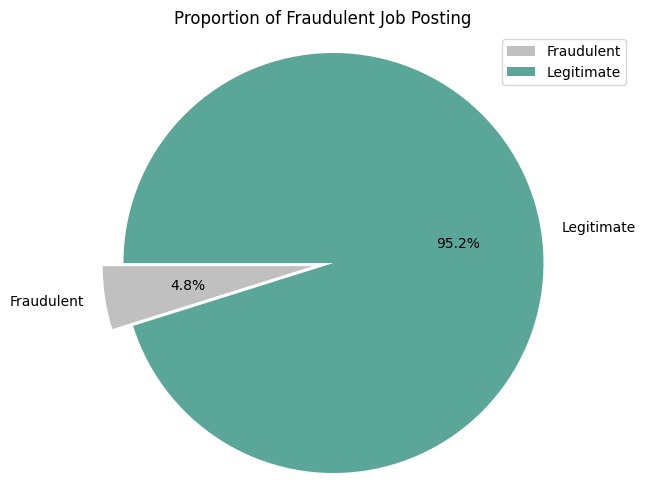

In [ ]:
labels = 'Fraudulent' ,'Legitimate'

sizes = [data_fake.fraudulent[data_fake['fraudulent'] == 1].count() ,data_fake.fraudulent[data_fake['fraudulent'] == 0].count()]
explode =(0,0.1)
#CFFFA6
colors=['#C0C0C0','#5aa698']
fig1 ,ax1 = plt.subplots(figsize =(8,6))
ax1.pie(sizes ,explode =explode, colors=colors, labels =labels, autopct ='%1.1f%%',startangle =180)

ax1.axis('equal')
plt.title("Proportion of Fraudulent Job Posting")
plt.legend()
plt.show()

In [ ]:
def bar_plt(col, titlecol, boolean = False):

    # count number of fraudulent postings and total postings -> calculate fraction of postings that are fraud
    fraudcnt = data_fake.groupby(col).fraudulent.sum().to_frame() # number fraud
    totcnt = data_fake.groupby(col).job_id.count().to_frame() # number in general
    frac = pd.merge(fraudcnt, totcnt, left_index = True, right_index = True) # merge
    frac['frac'] = frac.fraudulent / frac.job_id # fraction fraud

    # exclude if fewer than 10 total postings (else fraction may be close to 100%)
    frac = frac[frac.job_id > 10]

    # sort
    frac['index_col'] = frac.index
    frac = frac.reset_index(drop = True)
    # take top 10 if not boolean
    if boolean == False:
        frac = frac.sort_values('frac').tail(10)

    # plot
    cnt = len(frac)
    sns.barplot(x='index_col', y="frac", data=frac, order=frac['index_col'], color="#5aa698")

    # xtick format
    if boolean == False:
        plt.xticks(rotation=90)
    else:
        plt.xticks([0, 1], ['No', 'Yes'])

    # title
    # if top 10 was not the full amount, say top 10 in title. Else, all values
    if cnt == 10:
        plt.title('Top 10 ' + titlecol + ' by Percent Fraudulent Postings')
    else:
        plt.title(titlecol + ' by Percent Fraudulent Postings')

    # label
    plt.ylabel('Fraction of Fraudulent Postings')
    plt.xlabel('')

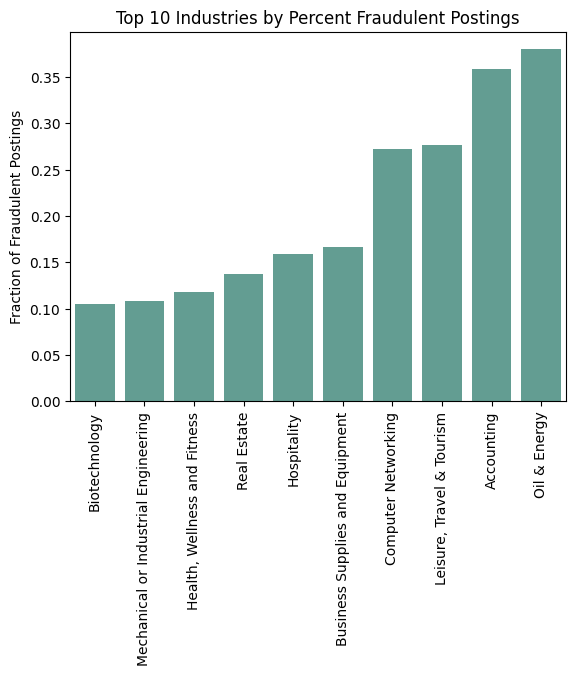

In [ ]:
bar_plt('industry', 'Industries')

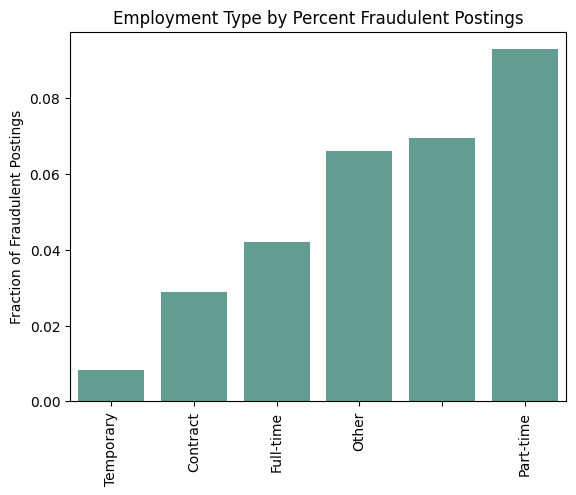

In [ ]:
bar_plt('employment_type', 'Employment Type')

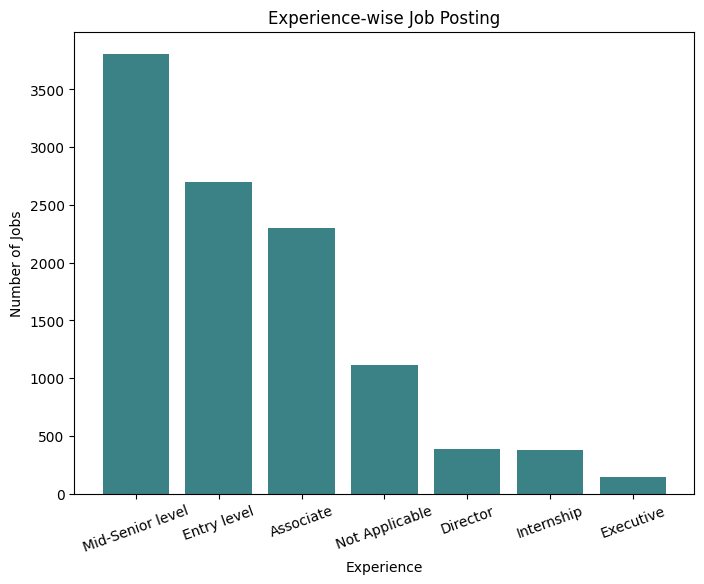

In [ ]:
# Visualize Job posting by Experience

experience =dict(data_fake.required_experience.value_counts())
del experience['']

plt.figure(figsize=(8,6))
plt.title('Experience-wise Job Posting')
plt.bar(experience.keys(),experience.values(), color='#3a8286')

plt.xlabel('Experience')
plt.ylabel('Number of Jobs')
plt.xticks (rotation=20)
plt.show()

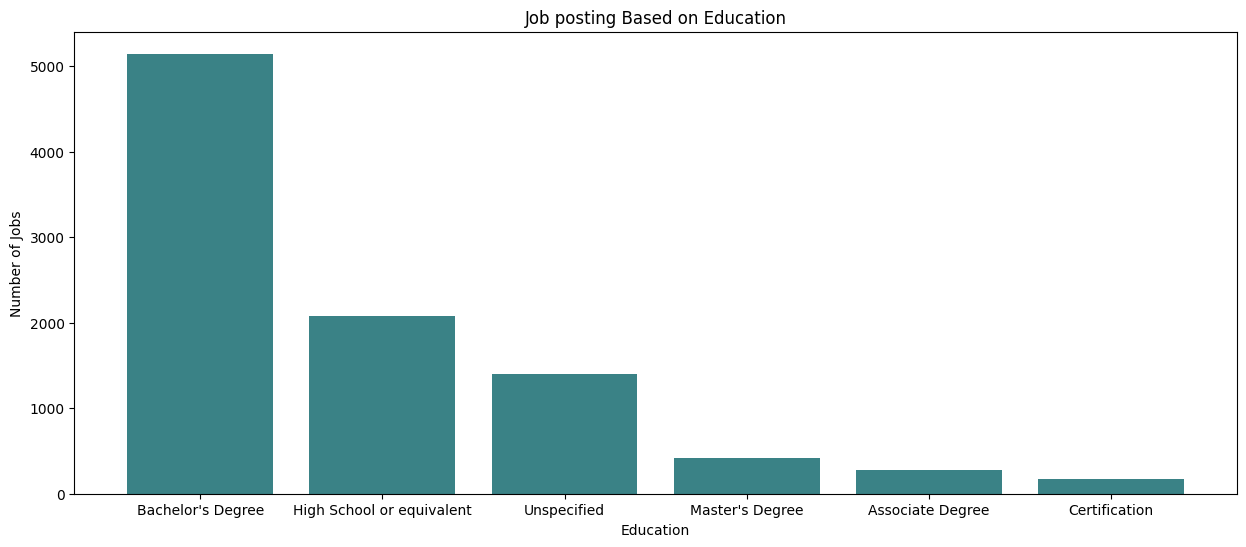

In [ ]:
# Visualize Job posting based on education

edu =dict(data_fake.required_education.value_counts()[:7])
del edu['']

plt.figure(figsize=(15,6))
plt.title('Job posting Based on Education')
plt.bar(edu.keys(),edu.values(), color='#3a8286')

plt.xlabel('Education')
plt.ylabel('Number of Jobs')
plt.show()


In [ ]:
#Legitimate Jobs
print(data_fake[data_fake.fraudulent == 0].title.value_counts()[:10])

English Teacher Abroad                                311
Customer Service Associate                            146
Graduates: English Teacher Abroad (Conversational)    144
English Teacher Abroad                                 95
Software Engineer                                      86
English Teacher Abroad (Conversational)                83
Customer Service Associate - Part Time                 76
Account Manager                                        73
Web Developer                                          66
Project Manager                                        62
Name: title, dtype: int64


In [ ]:
# Fraudulent Jobs
print(data_fake[data_fake.fraudulent == 1].title.value_counts()[:10])

Data Entry Admin/Clerical Positions - Work From Home                    21
Home Based Payroll Typist/Data Entry Clerks Positions Available         21
Cruise Staff Wanted *URGENT*                                            21
Customer Service Representative                                         17
Administrative Assistant                                                16
Home Based Payroll Data Entry Clerk Position - Earn $100-$200 Daily     12
Account Sales Managers $80-$130,000/yr                                  10
Network Marketing                                                       10
Payroll Clerk                                                           10
Payroll Data Coordinator Positions - Earn $100-$200 Daily               10
Name: title, dtype: int64


In [ ]:
data_fake.head()

,job_id,title,location,department,company_profile,description,requirements,benefits,employment_type,required_experience,required_education,industry,function,fraudulent
0,1,Marketing Intern,"US, NY, New York",Marketing,"We're Food52, and we've created a groundbreaki...","Food52, a fast-growing, James Beard Award-winn...",Experience with content management systems a m...,,Other,Internship,,,Marketing,0
1,2,Customer Service - Cloud Video Production,"NZ, , Auckland",Success,"90 Seconds, the worlds Cloud Video Production ...",Organised - Focused - Vibrant - Awesome!Do you...,What we expect from you:Your key responsibilit...,What you will get from usThrough being part of...,Full-time,Not Applicable,,Marketing and Advertising,Customer Service,0
2,3,Commissioning Machinery Assistant (CMA),"US, IA, Wever",,Valor Services provides Workforce Solutions th...,"Our client, located in Houston, is actively se...",Implement pre-commissioning and commissioning ...,,,,,,,0
3,4,Account Executive - Washington DC,"US, DC, Washington",Sales,Our passion for improving quality of life thro...,THE COMPANY: ESRI – Environmental Systems Rese...,"EDUCATION: Bachelor’s or Master’s in GIS, busi...",Our culture is anything but corporate—we have ...,Full-time,Mid-Senior level,Bachelor's Degree,Computer Software,Sales,0
4,5,Bill Review Manager,"US, FL, Fort Worth",,SpotSource Solutions LLC is a Global Human Cap...,JOB TITLE: Itemization Review ManagerLOCATION:...,QUALIFICATIONS:RN license in the State of Texa...,Full Benefits Offered,Full-time,Mid-Senior level,Bachelor's Degree,Hospital & Health Care,Health Care Provider,0


In [ ]:
data_fake['text'] = data_fake['title'] +' '+ data_fake['company_profile'] +' '+data_fake['description'] +' '+ data_fake['requirements'] + ' ' + data_fake['benefits']

del data_fake['title']
del data_fake['job_id']
del data_fake['location']
del data_fake['department']
del data_fake['company_profile']
del data_fake['description']
del data_fake['requirements']
del data_fake['benefits']
del data_fake['employment_type']
del data_fake['required_experience']
del data_fake['required_education']
del data_fake['industry']
del data_fake['function']

In [ ]:
data_fake.head()

,fraudulent,text
0,0,"Marketing Intern We're Food52, and we've creat..."
1,0,Customer Service - Cloud Video Production 90 S...
2,0,Commissioning Machinery Assistant (CMA) Valor ...
3,0,Account Executive - Washington DC Our passion ...
4,0,Bill Review Manager SpotSource Solutions LLC i...


In [ ]:
!pip install spacy && python m spacy download en

python3: can't open file '/content/m': [Errno 2] No such file or directory


In [ ]:
#Cleaning and preprocessing
#Create the list of punctuation marks
punctuations=string.punctuation

#Create the list of stopwords
nlp=spacy.load("en_core_web_sm")
stop_words = spacy.lang.en.stop_words.STOP_WORDS

#Load english tokenizer, tagger, parser, NER, and word vectors
parser=English()

#Creating the tokenizer function
def spacy_tokenizer(sentence):
  mytokens=parser(sentence)
  mytokens=[word.lemma_.lower().strip() if word.lemma_ != '-PRON-' else word.lower_ for word in mytokens]
  mytokens=[word for word in mytokens if word not in stop_words and word not in punctuations]
  return mytokens

class predictors(TransformerMixin):
  def transform(self, X, **transform_params):
    return [clean_text(test) for text in X]
  def fit(self, X, y=None, **fit_params):
    return self
  def get_params(self, deep=True):
    return {}

#Basic function to clean the text
def clean_text(text):
  return text.strip().lower()

/usr/local/lib/python3.10/dist-packages/spacy/util.py:910: UserWarning: [W095] Model 'en_core_web_sm' (3.6.0) was trained with spaCy v3.6.0 and may not be 100% compatible with the current version (3.7.2). If you see errors or degraded performance, download a newer compatible model or retrain your custom model with the current spaCy version. For more details and available updates, run: python -m spacy validate
  warnings.warn(warn_msg)


In [ ]:
data_fake['text']=data_fake['text'].apply(clean_text)

**Extreme Learning Machine (ELM) Method**

In [ ]:
!pip install scikit-elm --upgrade

In [ ]:
from skelm import ELMClassifier

In [ ]:
Y=data_fake['fraudulent']
X=data_fake['text']

# Split the data for different proportions
proportions = [0.8, 0.7, 0.85]

for proportion in proportions:
    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=(1 - proportion), random_state=42)

    # Inisialisasi TfidfVectorizer
    vectorizer = TfidfVectorizer()

    # Transformasi teks menjadi vektor TF-IDF
    xv_train = vectorizer.fit_transform(X_train)
    xv_test = vectorizer.transform(X_test)

    # Initialize the Decision Tree classifier
    elm = ELMClassifier(random_state=42)

    # Fit the model on the training data
    elm.fit(xv_train, y_train)

    # Make predictions on the test set
    pred = elm.predict(xv_test)

    # Evaluate the model's performance
    accuracy = accuracy_score(y_test, pred)
    precision = precision_score(y_test, pred)
    recall = recall_score(y_test, pred)
    f1 = f1_score(y_test, pred)

    # Print results
    print(f"\nProportion {proportion * 100:.0f}% Training - {100 - proportion * 100:.0f}% Testing:")
    print("Accuracy:", accuracy)
    print("Precision:", precision)
    print("Recall:", recall)
    print("F1 Score:", f1)

    print("Classification Report\n")
    print(classification_report(y_test,pred))
    print("Confusion Matrix")
    print(confusion_matrix(y_test,pred))


Proportion 80% Training - 20% Testing:
Accuracy: 0.9823825503355704
Precision: 1.0
Recall: 0.6519337016574586
F1 Score: 0.7892976588628763
Classification Report

              precision    recall  f1-score   support

           0       0.98      1.00      0.99      3395
           1       1.00      0.65      0.79       181

    accuracy                           0.98      3576
   macro avg       0.99      0.83      0.89      3576
weighted avg       0.98      0.98      0.98      3576

Confusion Matrix
[[3395    0]
 [  63  118]]

Proportion 70% Training - 30% Testing:
Accuracy: 0.9802423112767941
Precision: 0.9714285714285714
Recall: 0.6273062730627307
F1 Score: 0.7623318385650224
Classification Report

              precision    recall  f1-score   support

           0       0.98      1.00      0.99      5094
           1       0.97      0.63      0.76       271

    accuracy                           0.98      5365
   macro avg       0.98      0.81      0.88      5365
weighted avg    